In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

from utils import *
from calibrators import *

from sklearn.model_selection import train_test_split
from collections import Counter

Import data from csv

In [4]:
df = load_df("data")
# Clean up the column names that seem to have leading spaces
df.columns = df.columns.str.strip()

calib_data = import_from_dataframe(df)

## Average Offset Calibrator

In [4]:
aoc = AverageOffsetCalibrator(calib_data)

Compare for each gaze point in the data and their corresponding target point, what we got as a calibrated point.

In [5]:
new_columns = df.apply(
    lambda row: aoc.calibrate((row["gazePointX"], row["gazePointY"])),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

aoc_df = pd.concat([df, new_columns], axis=1)

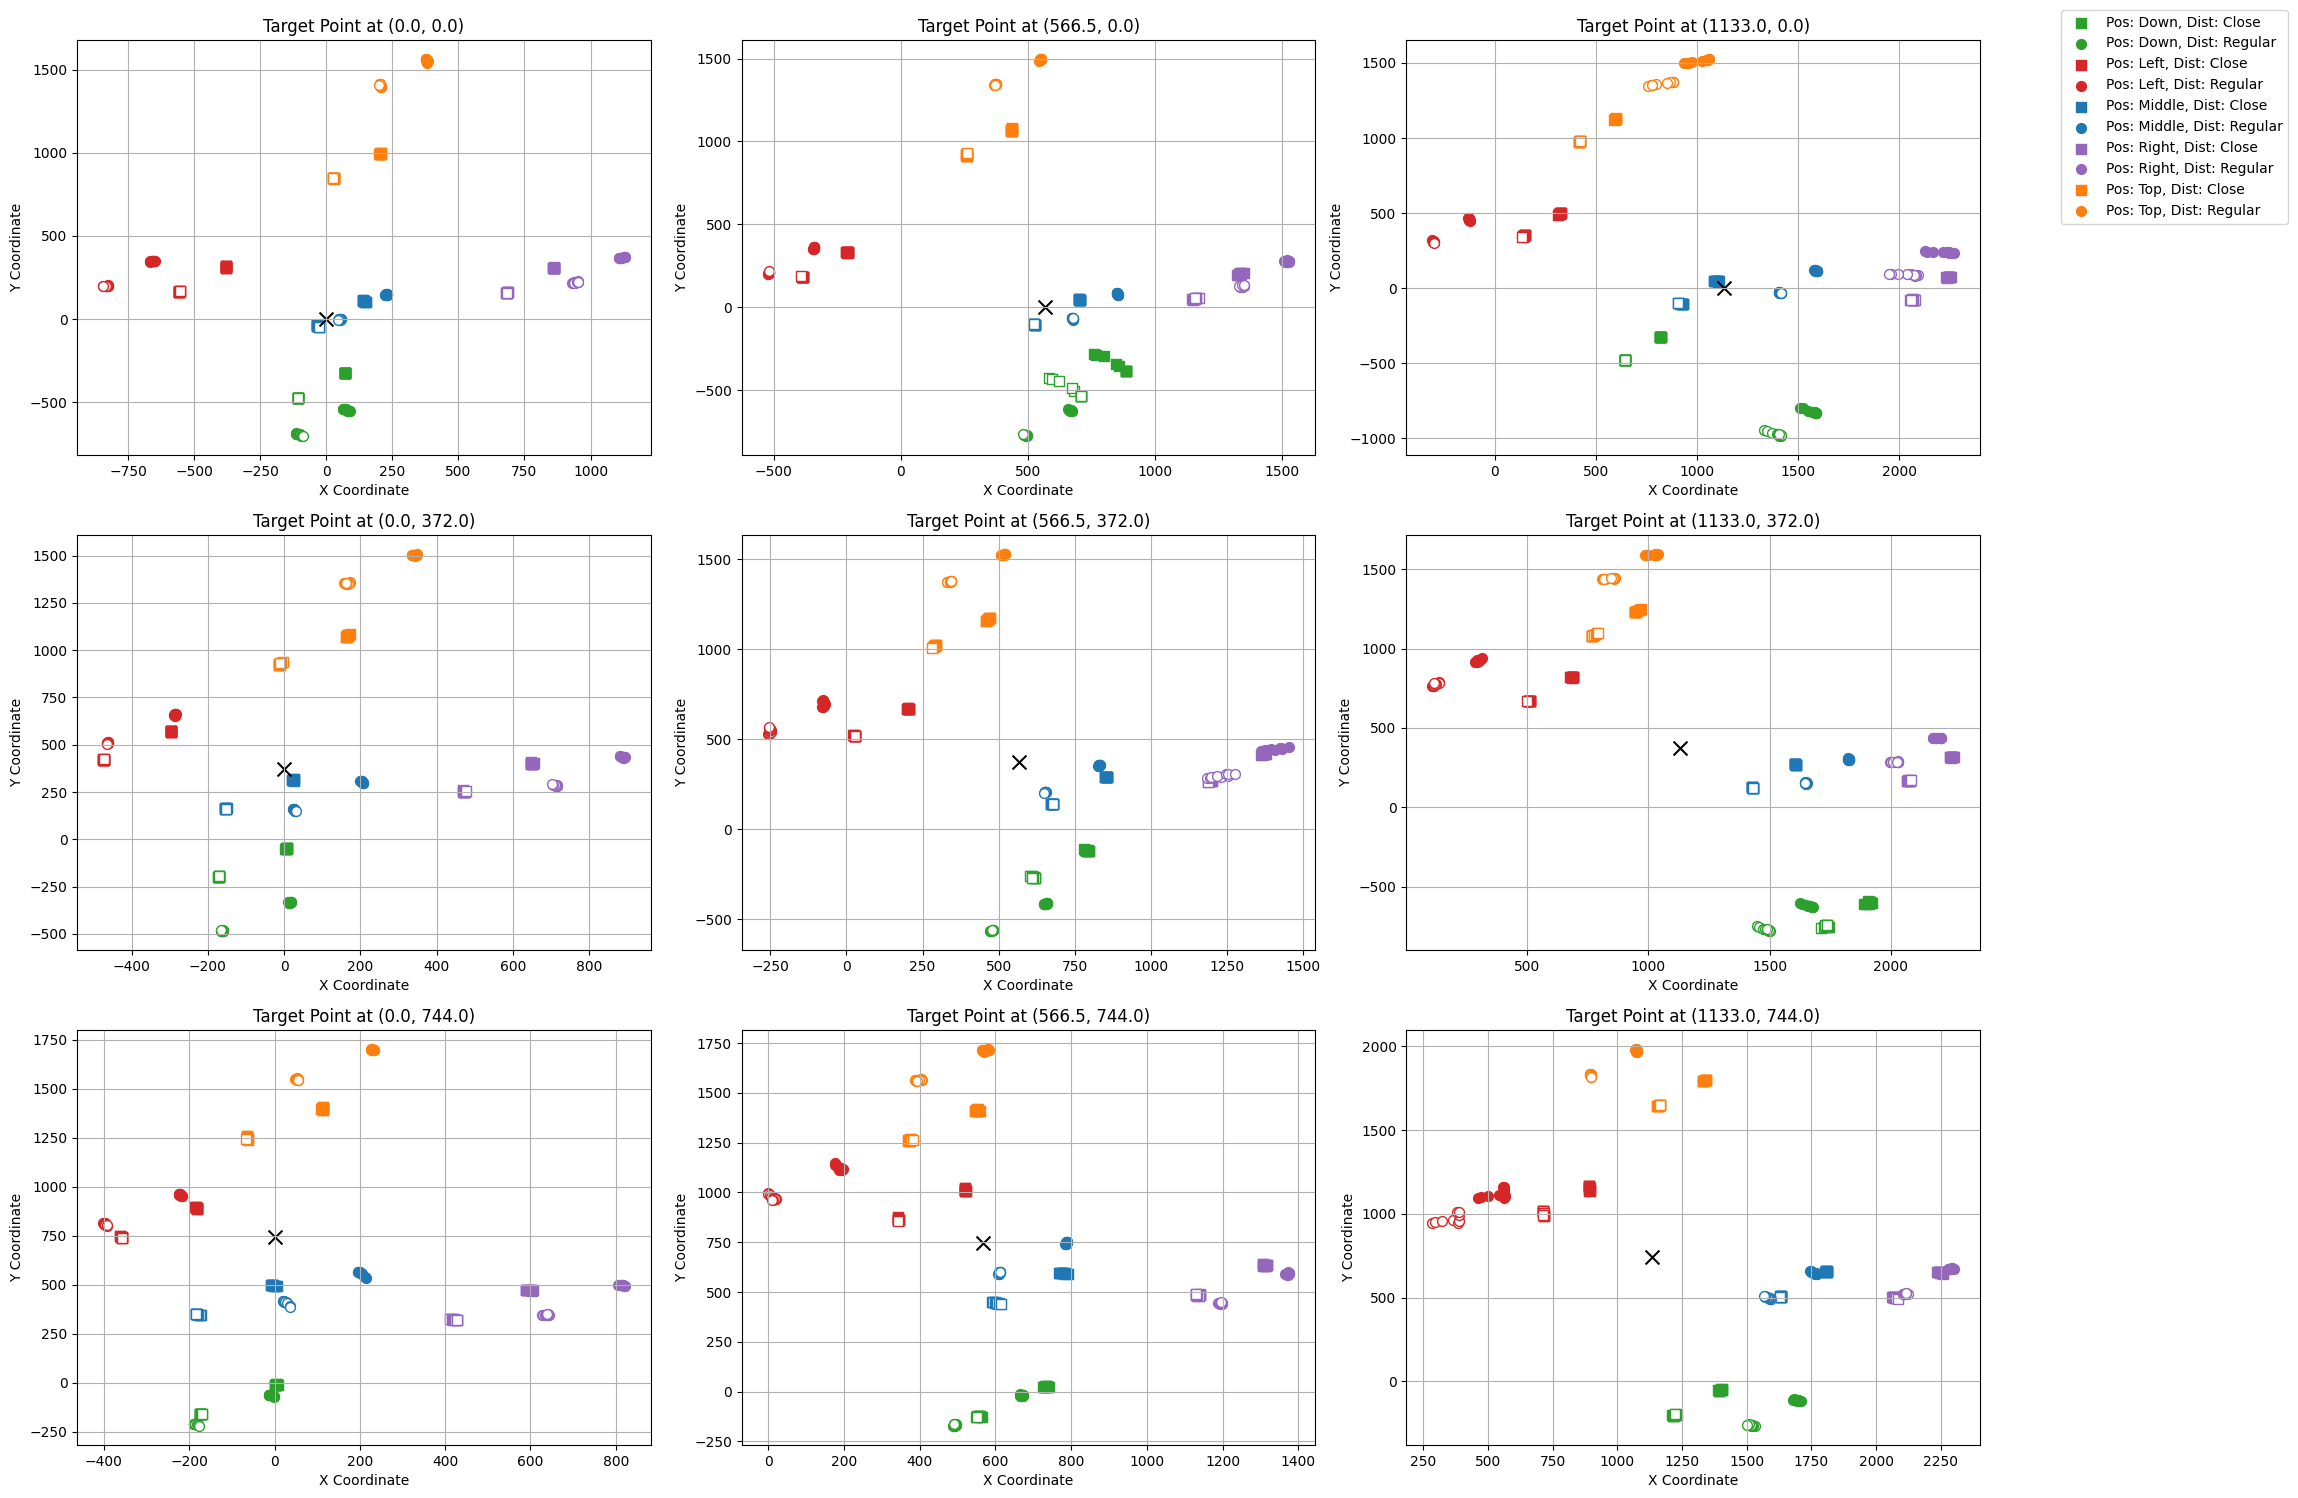

In [6]:
show_subplots(aoc_df, with_calib=True)

## Weighted Average Offset Calibrator

Weights the offset by how straight the face is. The more the face is straight, the more the offset is considered.

In [7]:
woc = WeightedOffsetCalibrator(calib_data)

In [8]:
new_columns = df.apply(
    lambda row: woc.calibrate((row["gazePointX"], row["gazePointY"])),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

woc_df = pd.concat([df, new_columns], axis=1)

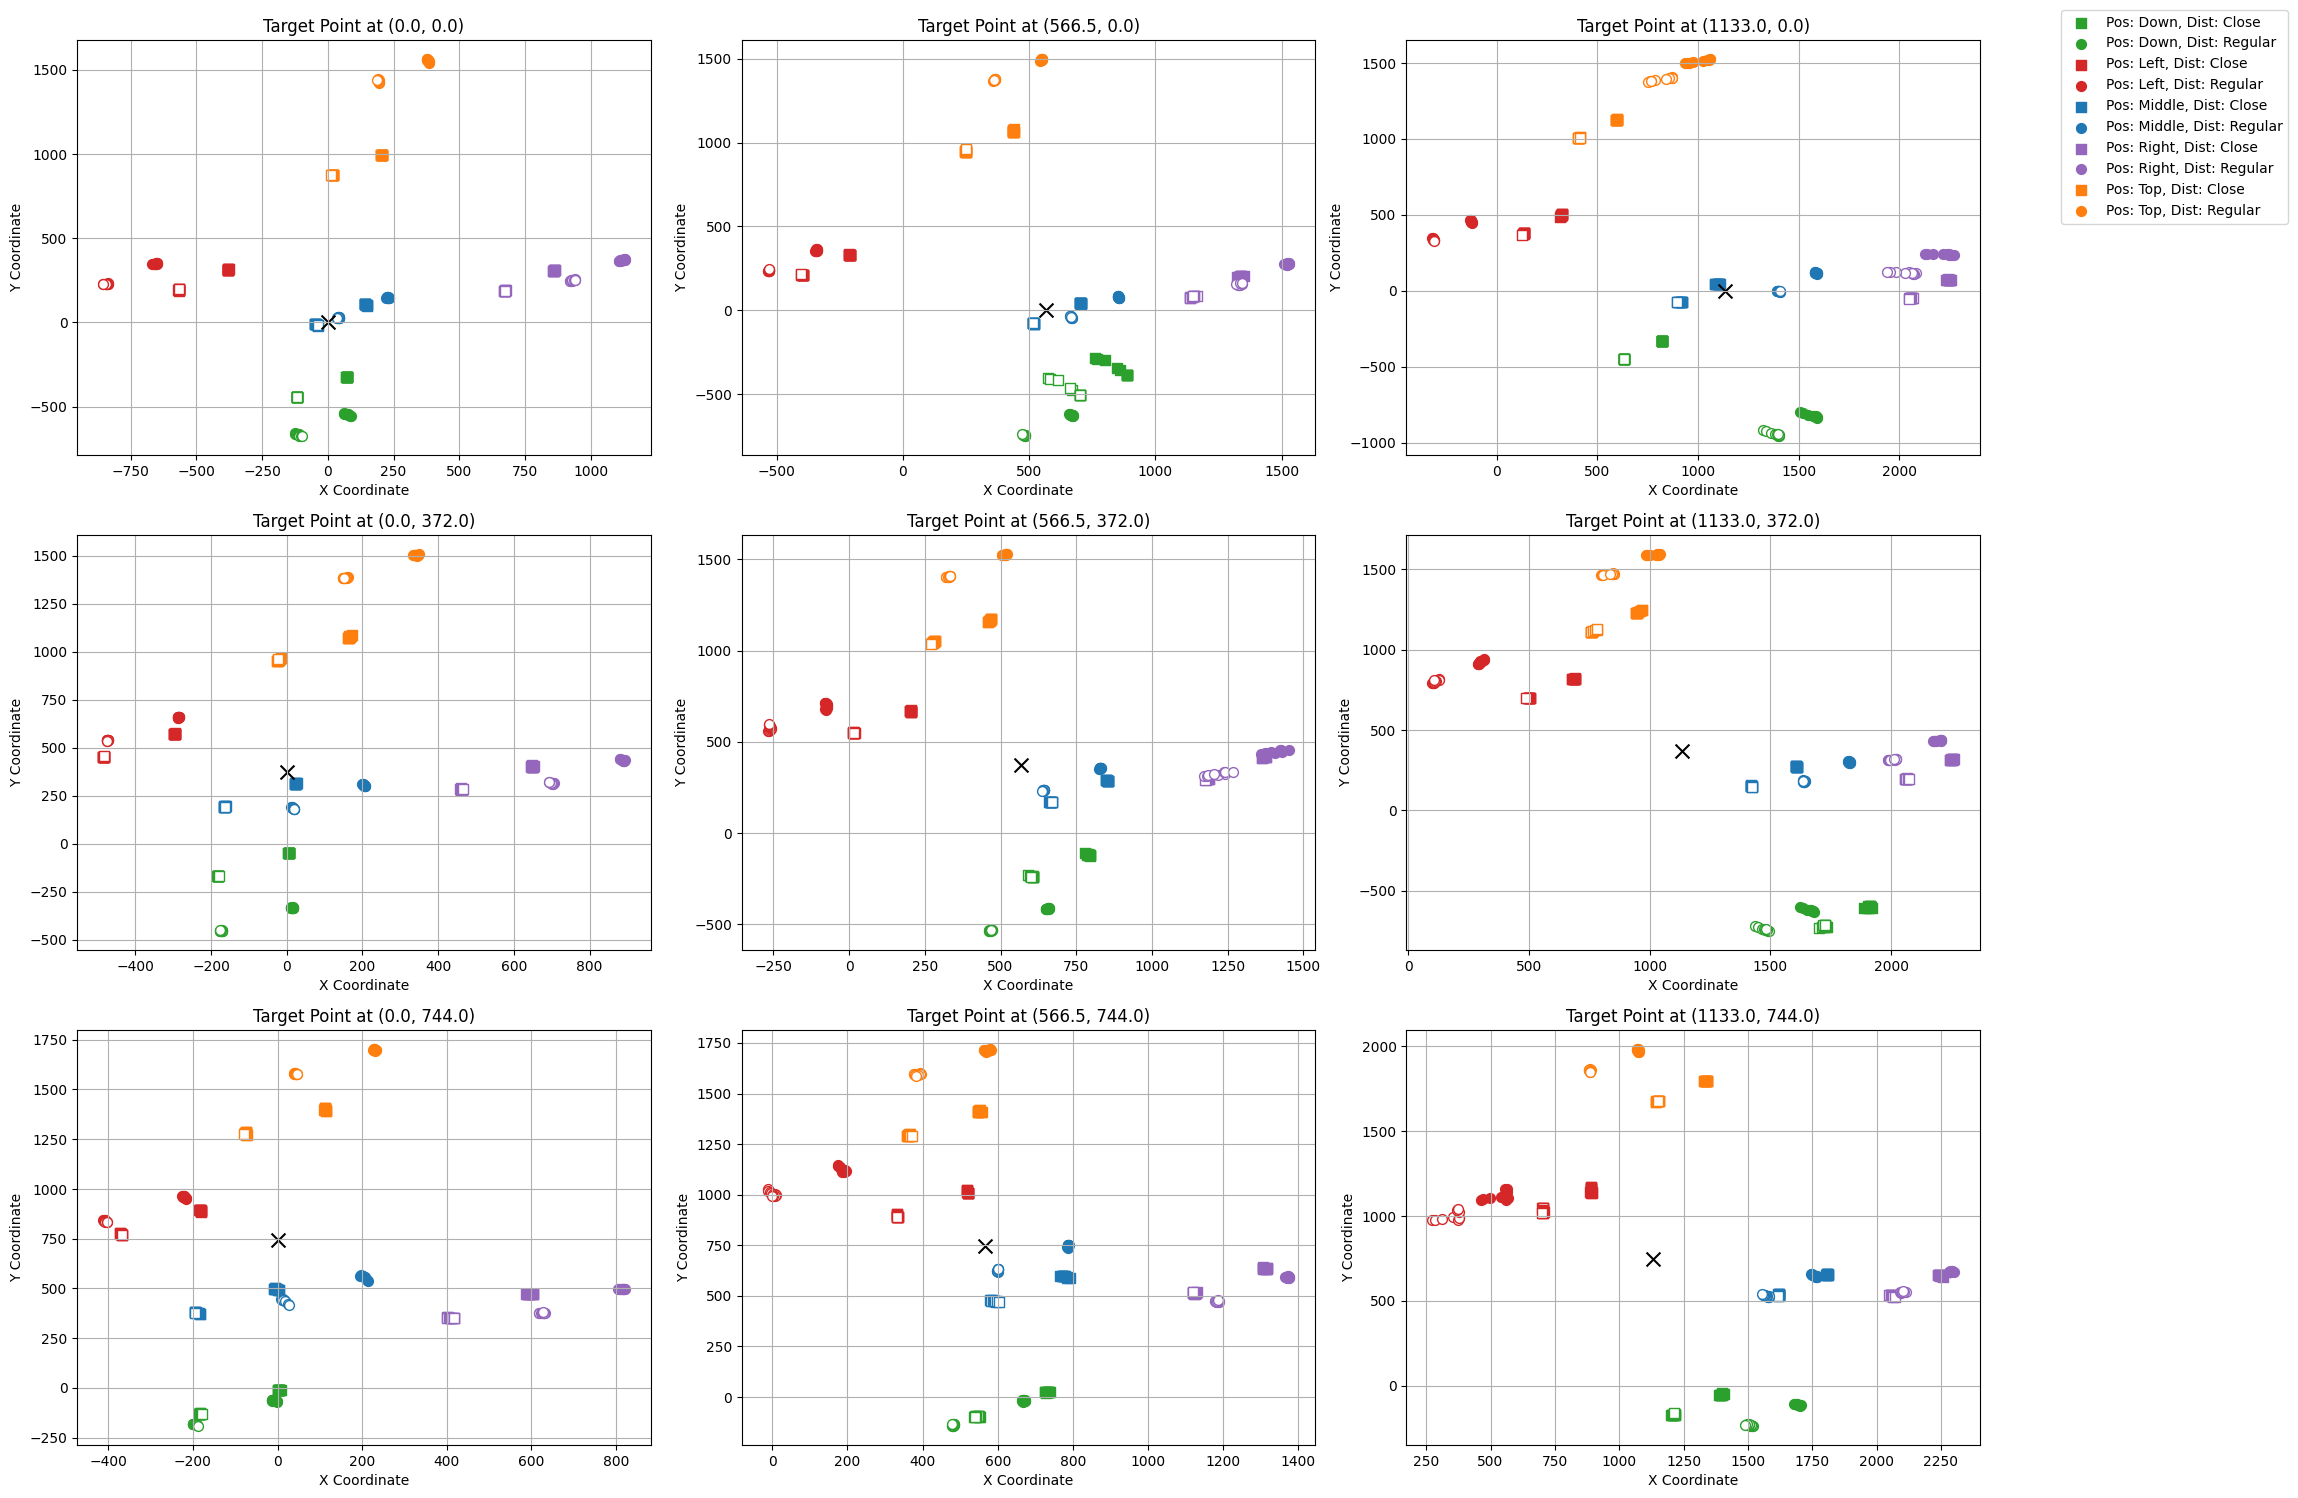

In [9]:
show_subplots(woc_df, with_calib=True)

## Linear Regression

### Setup

In [5]:
# Dropping the 'timestamp' column as it's not needed for the median calculation
# data = df.drop(columns="timestamp")

# List of columns to group by
group_columns = [
    "username",
    "deviceName",
    "position",
    "distance",
    "targetPointX",
    "targetPointY",
]

# Columns to compute the median
# Exclude group columns and any other non-required columns (like 'timestamp')
median_columns = [col for col in df.columns if col not in group_columns]

# Grouping by specified columns and computing the median of the rest of the columns
grouped_data = df.groupby(group_columns)[median_columns].median().reset_index()

display(grouped_data.head())

,username,deviceName,position,distance,targetPointX,targetPointY,timestamp,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_2_y,leftEyeTransform_2_z,leftEyeTransform_2_w,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ
0,victor,iPad Mini 6th,Down,Close,0.0,0.0,1.715694e+09,70.988760,-324.538195,0.998787,...,0.124934,0.954078,0.0,0.031738,0.029988,0.024180,1.0,-0.207724,0.145160,0.870479
1,victor,iPad Mini 6th,Down,Close,0.0,372.0,1.715694e+09,5.810137,-48.642838,0.998952,...,0.048346,0.956427,0.0,0.032182,0.031637,0.023821,1.0,-0.212063,0.074501,0.836008
2,victor,iPad Mini 6th,Down,Close,0.0,744.0,1.715694e+09,3.500565,-9.812429,0.997390,...,0.136845,0.956815,0.0,0.032198,0.031979,0.023494,1.0,-0.197576,0.160285,0.890163
3,victor,iPad Mini 6th,Down,Close,566.5,0.0,1.715694e+09,873.400326,-371.883272,0.999518,...,0.093463,0.989167,0.0,0.031631,0.028292,0.024956,1.0,0.112326,0.096527,0.742844
4,victor,iPad Mini 6th,Down,Close,566.5,372.0,1.715694e+09,791.603750,-119.648882,0.998964,...,0.103742,0.989164,0.0,0.032214,0.031813,0.023788,1.0,0.117347,0.118060,0.841723


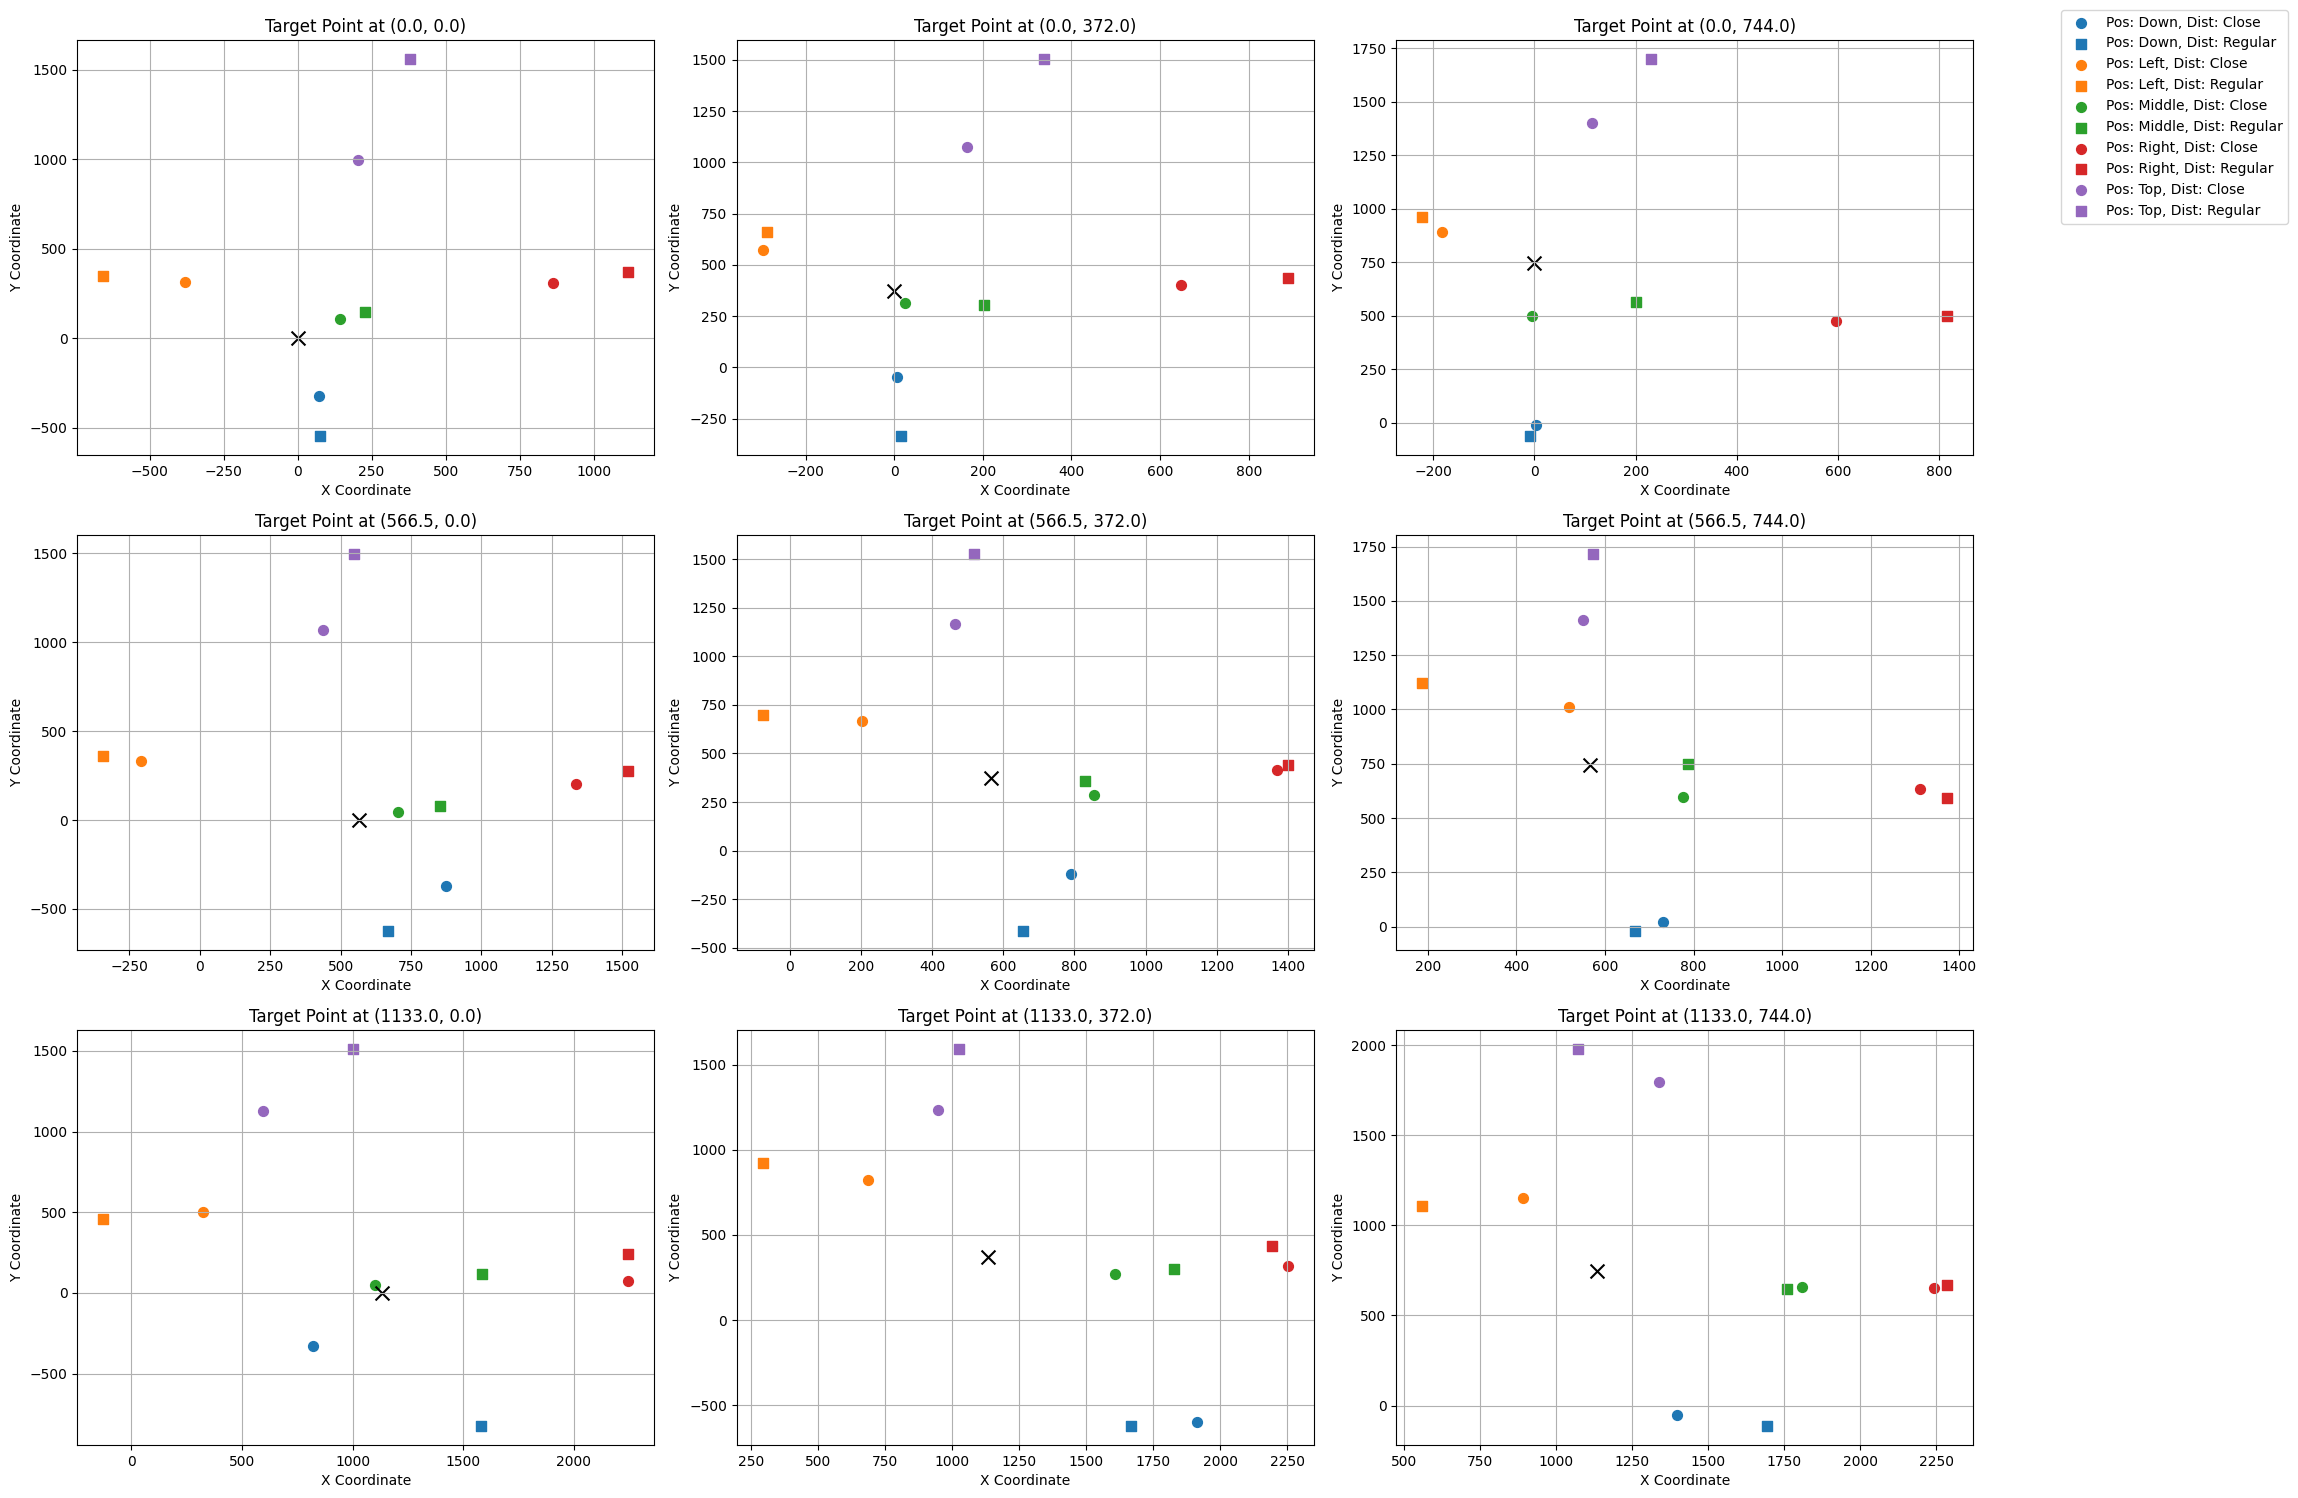

In [6]:
show_subplots(grouped_data)

In [7]:
grouped_calib_data = import_from_dataframe(grouped_data)

### Test using all points

In [8]:
lrc = LinearRegressionCalibrator(grouped_calib_data)

In [9]:
new_columns = grouped_data.apply(
    lambda row: lrc.calibrate(
        (row["gazePointX"], row["gazePointY"]), extract_face_transform(row)
    ),
    axis=1,
    result_type="expand",
)

# Assign new column names to the resulting DataFrame
new_columns.columns = ["calibratedPointX", "calibratedPointY"]

lrc_df = pd.concat([grouped_data, new_columns], axis=1)

display(lrc_df.head())

,username,deviceName,position,distance,targetPointX,targetPointY,timestamp,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_2_w,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,calibratedPointX,calibratedPointY
0,victor,iPad Mini 6th,Down,Close,0.0,0.0,1.715694e+09,70.988760,-324.538195,0.998787,...,0.0,0.031738,0.029988,0.024180,1.0,-0.207724,0.145160,0.870479,-9.536743e-07,0.000000
1,victor,iPad Mini 6th,Down,Close,0.0,372.0,1.715694e+09,5.810137,-48.642838,0.998952,...,0.0,0.032182,0.031637,0.023821,1.0,-0.212063,0.074501,0.836008,-9.163930e+01,416.241796
2,victor,iPad Mini 6th,Down,Close,0.0,744.0,1.715694e+09,3.500565,-9.812429,0.997390,...,0.0,0.032198,0.031979,0.023494,1.0,-0.197576,0.160285,0.890163,-1.701516e+01,690.690954
3,victor,iPad Mini 6th,Down,Close,566.5,0.0,1.715694e+09,873.400326,-371.883272,0.999518,...,0.0,0.031631,0.028292,0.024956,1.0,0.112326,0.096527,0.742844,9.290046e+02,-56.654552
4,victor,iPad Mini 6th,Down,Close,566.5,372.0,1.715694e+09,791.603750,-119.648882,0.998964,...,0.0,0.032214,0.031813,0.023788,1.0,0.117347,0.118060,0.841723,5.354546e+02,508.353729


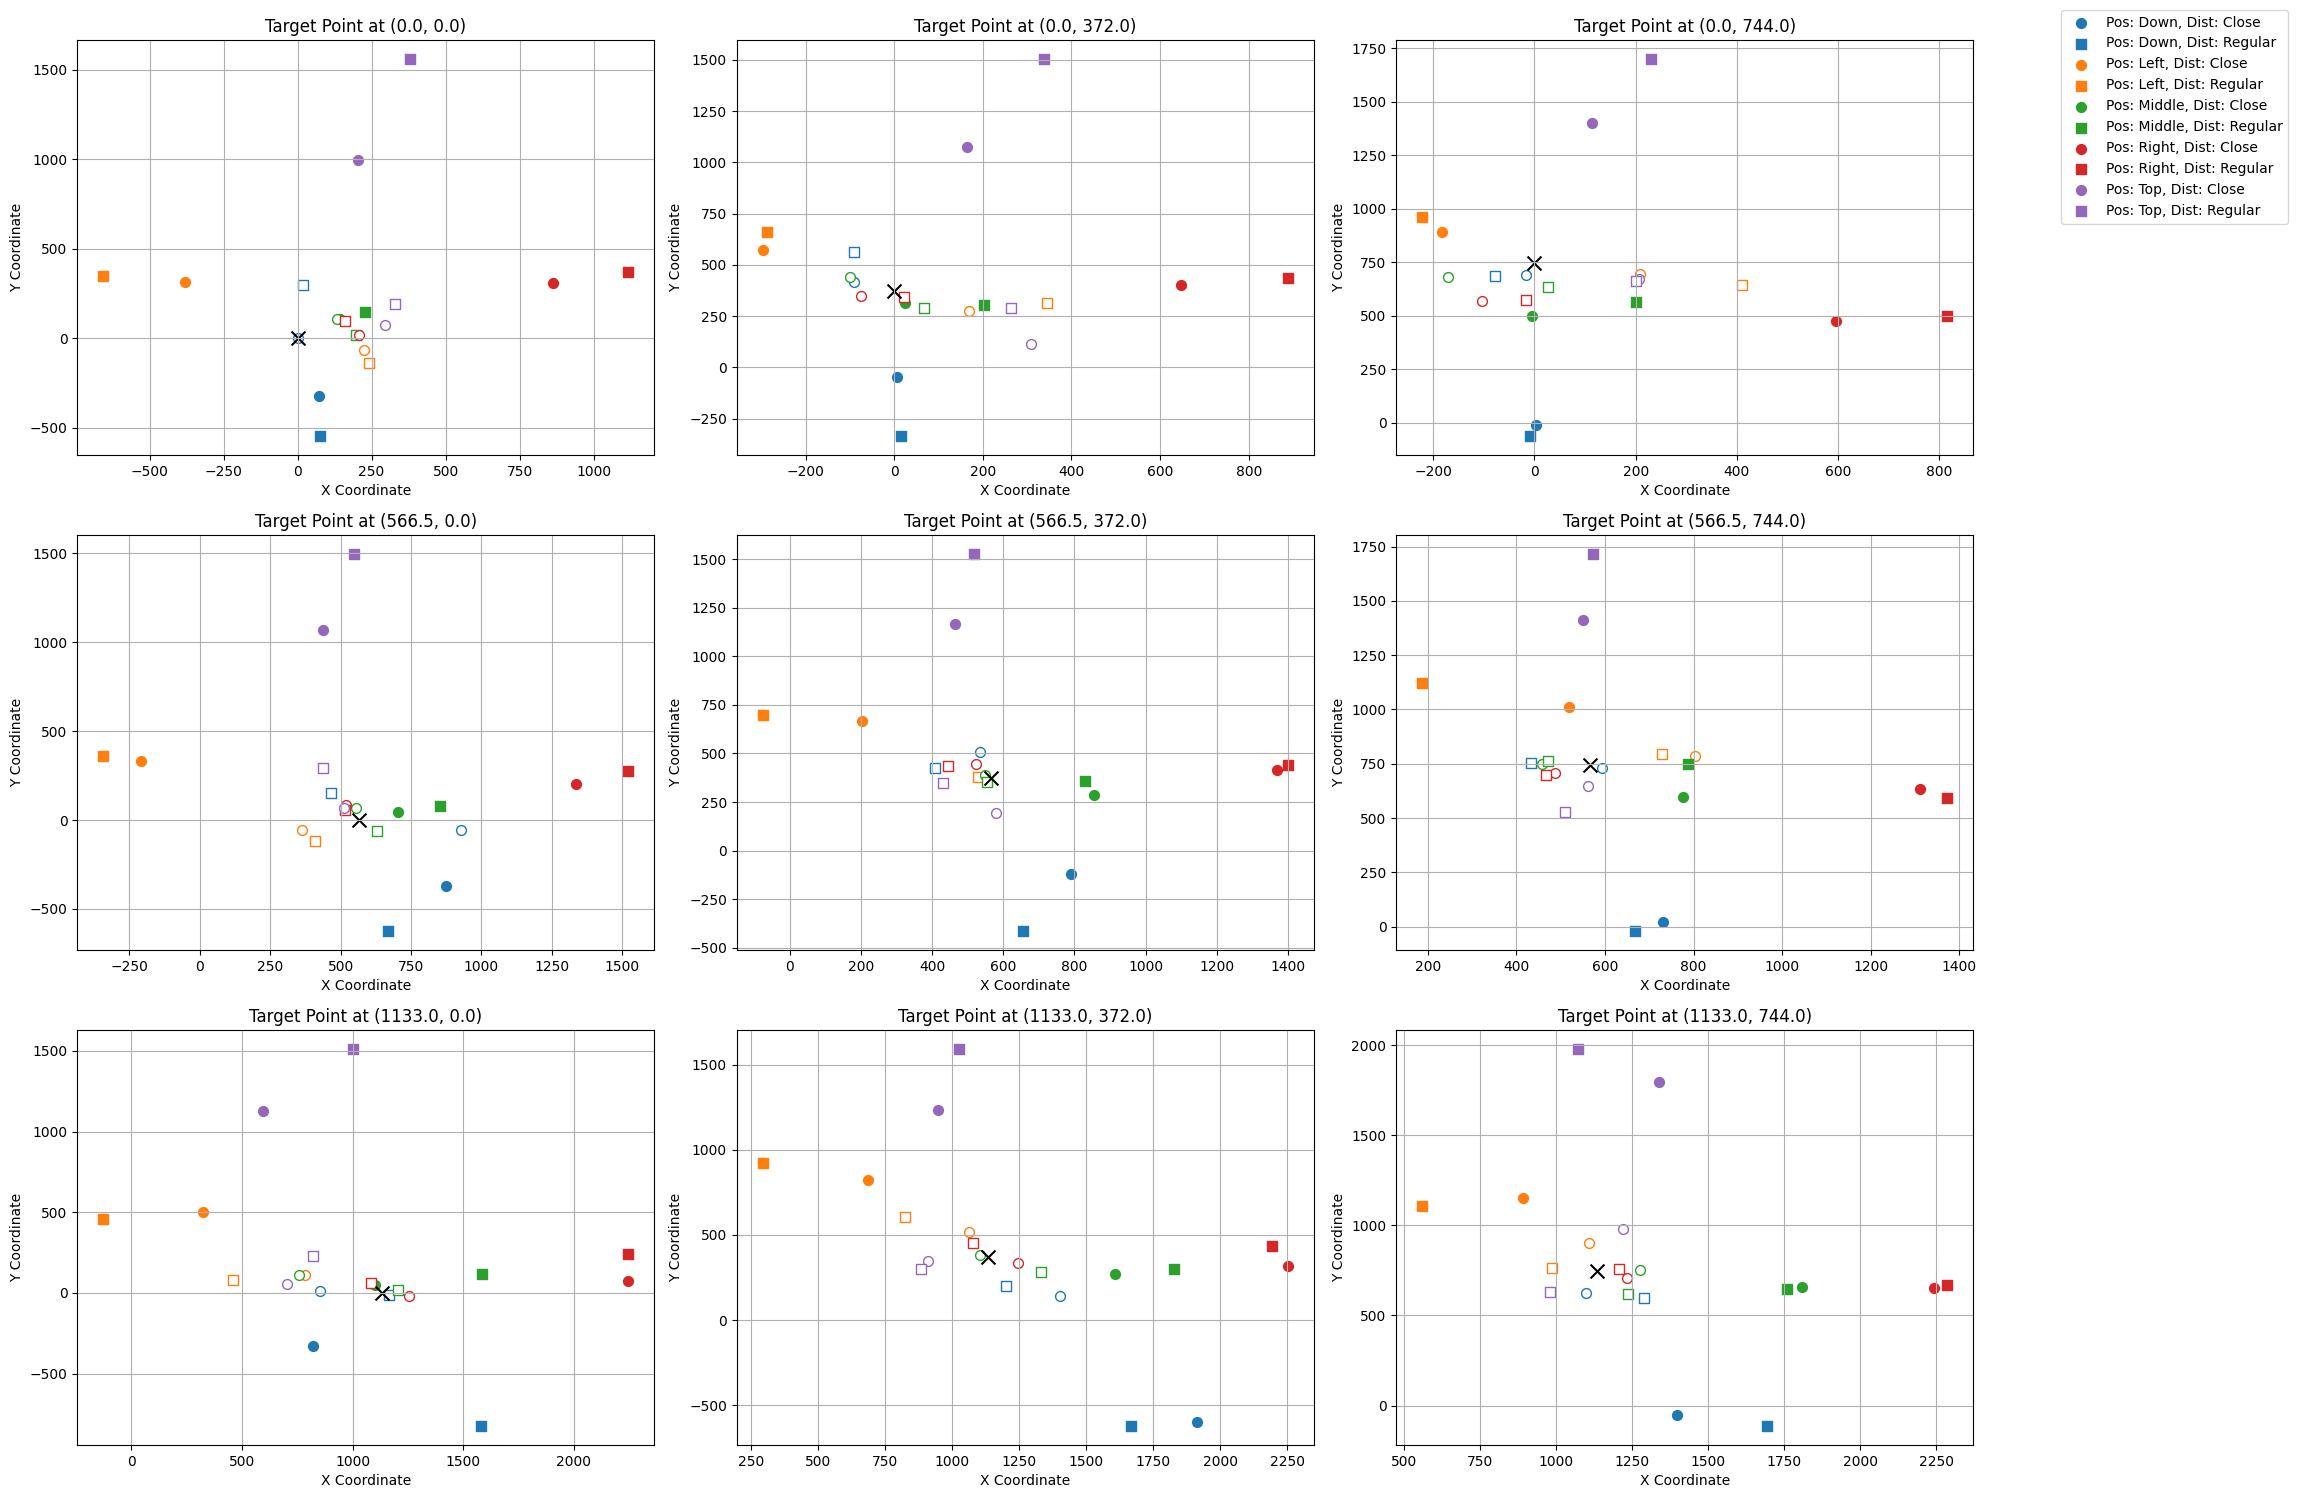

In [10]:
show_subplots(lrc_df, with_calib=True)

### Test using subset of points to test

**Split in trainset and testing set**

We are going to test the following setup:
- 

In [11]:
stratify_labels = [
    f"{cd.position.value}_{cd.distance.value}" for cd in grouped_calib_data
]

# Check distribution of stratification labels to ensure there's enough data for each category
label_distribution = Counter(stratify_labels)
print("Label Distribution:", label_distribution)

# It's important that no label has too few samples to be split correctly
# Adjust `min_count` based on your data size and the results of the distribution printout
min_count = 2
valid_indices = [
    i
    for i, label in enumerate(stratify_labels)
    if label_distribution[label] >= min_count
]

# Filter data and labels to include only those that have enough samples
filtered_data = [grouped_calib_data[i] for i in valid_indices]
filtered_labels = [stratify_labels[i] for i in valid_indices]

# Split data using train_test_split from scikit-learn, stratifying by the filtered labels
train_data, test_data = train_test_split(
    filtered_data, test_size=0.25, stratify=filtered_labels, random_state=42
)

print("Training Data Length:", len(train_data))
print("Testing Data Length:", len(test_data))

Label Distribution: Counter({'Down_Close': 9, 'Down_Regular': 9, 'Left_Close': 9, 'Left_Regular': 9, 'Middle_Close': 9, 'Middle_Regular': 9, 'Right_Close': 9, 'Right_Regular': 9, 'Top_Close': 9, 'Top_Regular': 9})
Training Data Length: 67
Testing Data Length: 23


In [18]:
train_df = calib_data_to_dataframe(train_data)
display(train_df.head())
test_df = calib_data_to_dataframe(test_data)

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_2_y,leftEyeTransform_2_z,leftEyeTransform_2_w,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ
0,victor,iPad Mini 6th,Left,Close,1.715694e+09,0.0,744.0,-182.233968,892.401265,0.906594,...,-0.043974,0.982889,0.0,0.032736,0.032172,0.024076,1.0,0.195152,-0.008467,0.917794
1,victor,iPad Mini 6th,Left,Close,1.715694e+09,1133.0,744.0,890.497411,1153.560795,0.925360,...,0.062105,0.855612,0.0,0.032716,0.032155,0.024082,1.0,0.671693,0.122484,1.090240
2,victor,iPad Mini 6th,Down,Close,1.715694e+09,0.0,372.0,5.810137,-48.642838,0.998952,...,0.048346,0.956427,0.0,0.032182,0.031637,0.023821,1.0,-0.212063,0.074501,0.836008
3,victor,iPad Mini 6th,Down,Close,1.715694e+09,1133.0,372.0,1912.726780,-601.317611,0.999599,...,0.013754,0.873003,0.0,0.032215,0.031817,0.023799,1.0,0.612152,0.050608,1.062210
4,victor,iPad Mini 6th,Down,Close,1.715694e+09,566.5,0.0,873.400326,-371.883272,0.999518,...,0.093463,0.989167,0.0,0.031631,0.028292,0.024956,1.0,0.112326,0.096527,0.742844


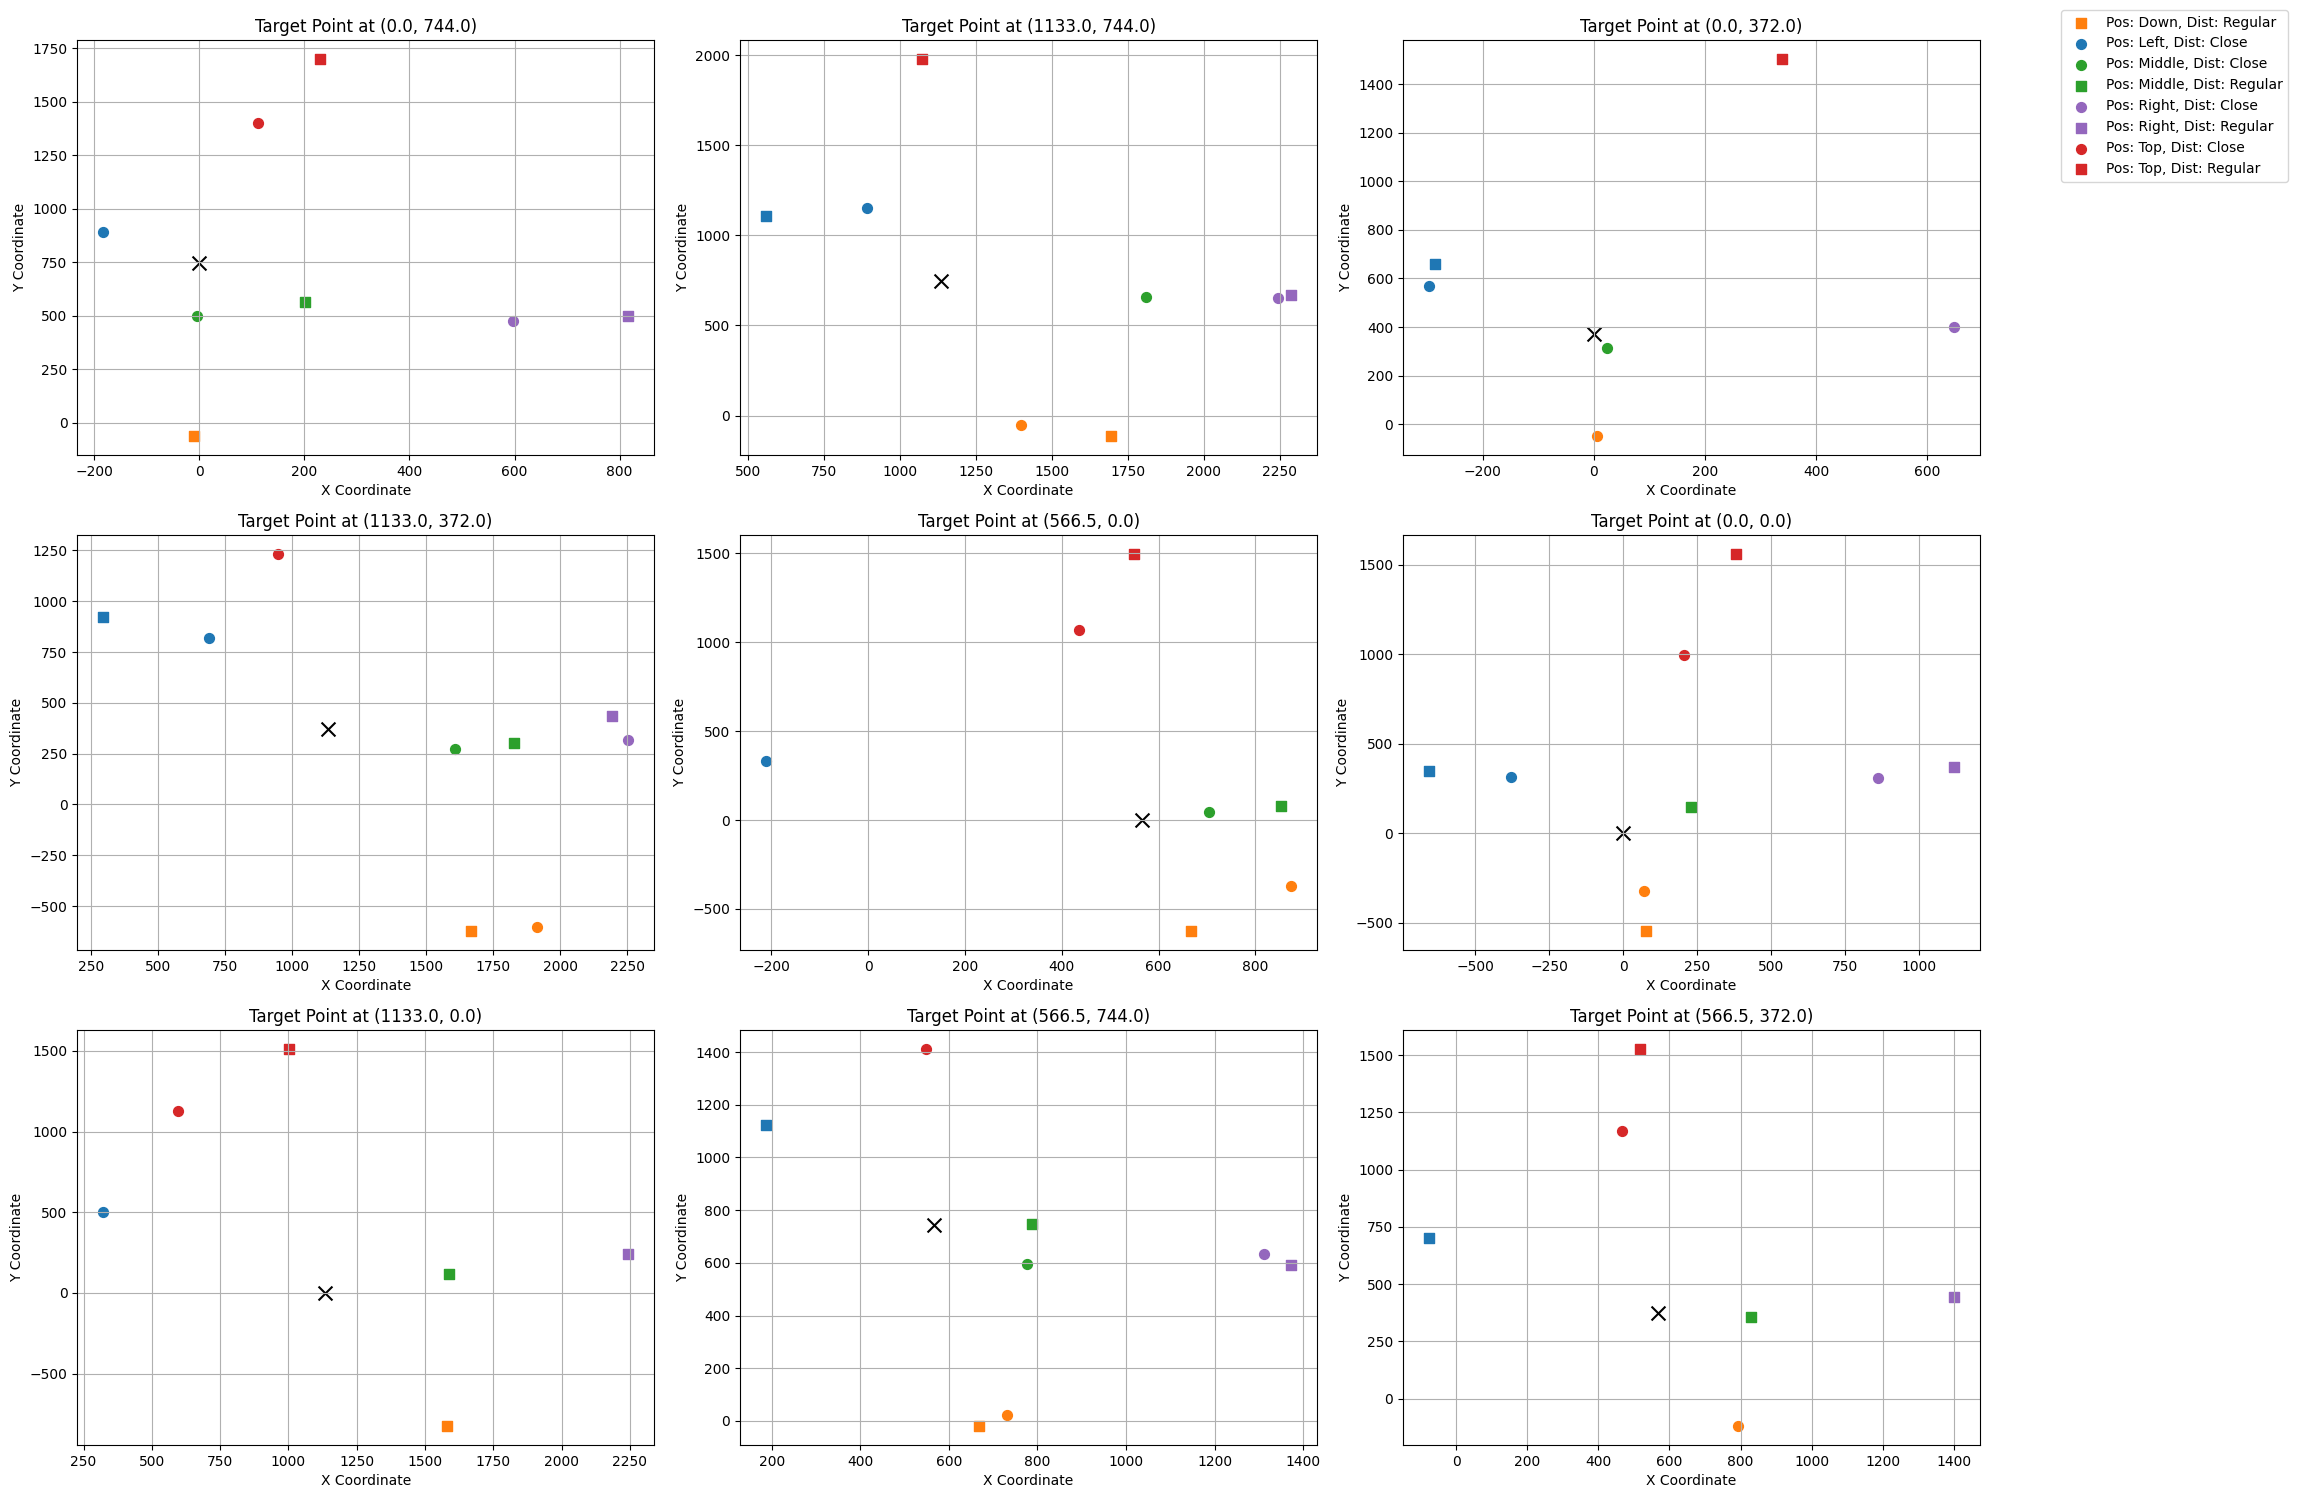

In [19]:
show_subplots(train_df)

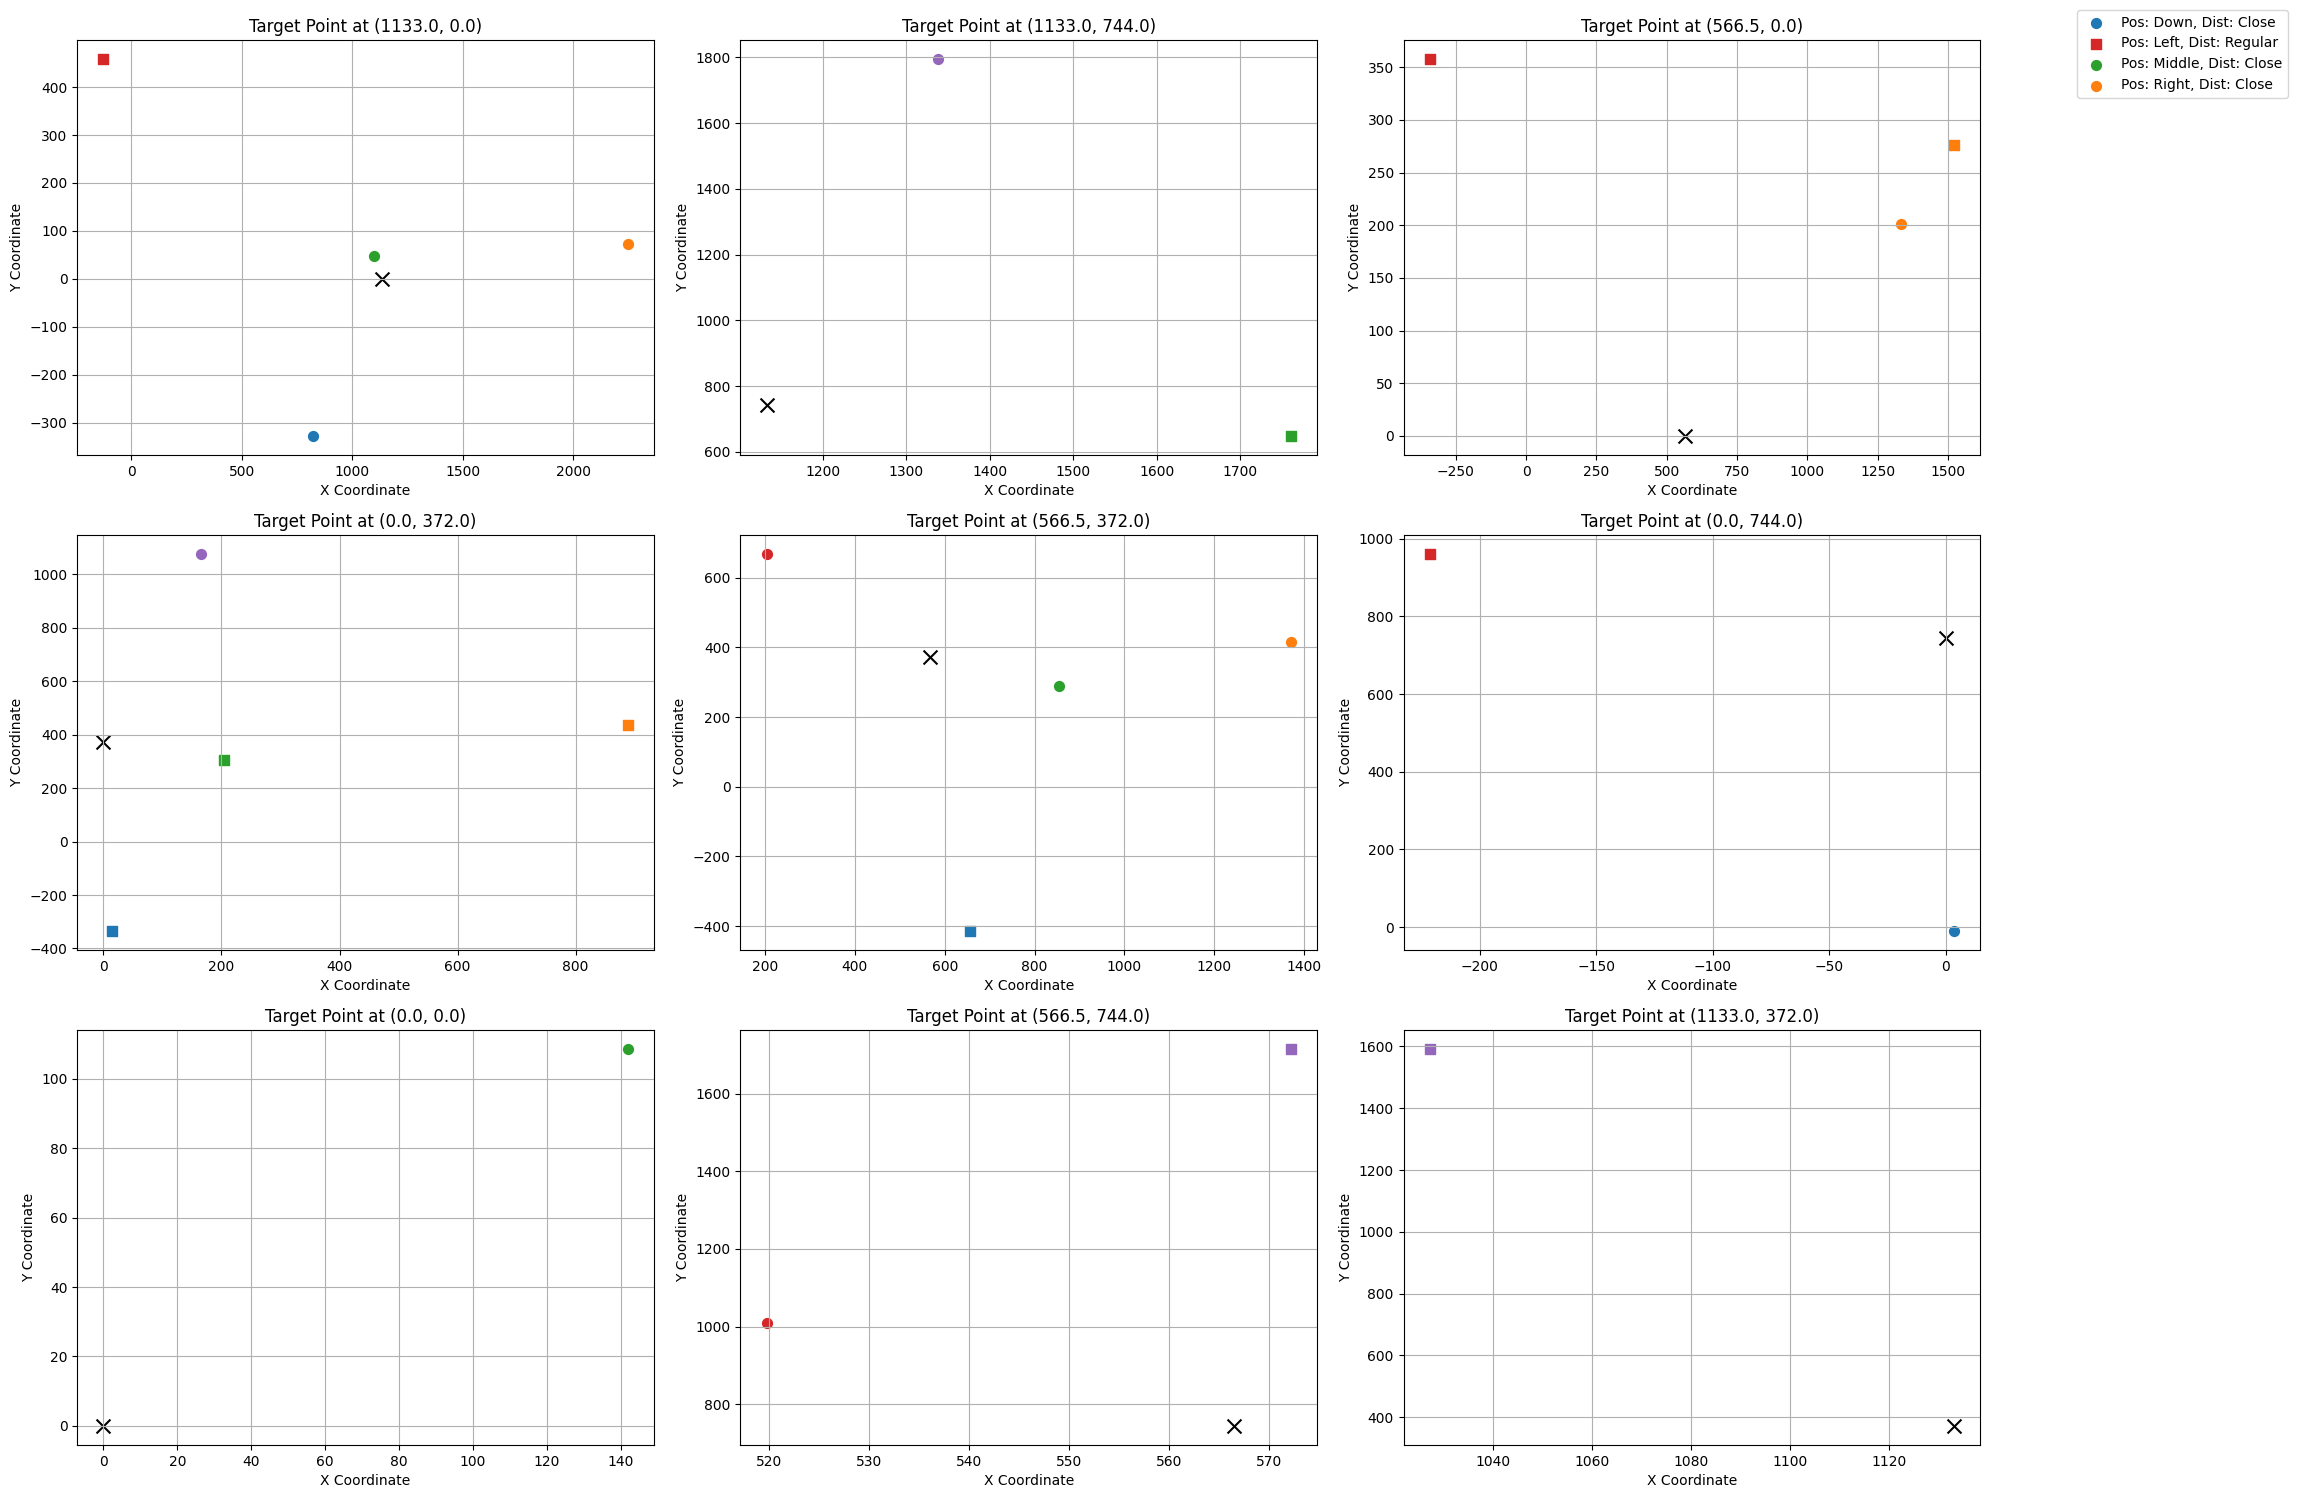

In [20]:
show_subplots(test_df)

In [13]:
split_lrc = LinearRegressionCalibrator(train_data)

In [14]:
evaluation_results = split_lrc.evaluate(test_data)
print(evaluation_results)

X_test:
 [[ 8.19867319e+02 -3.27625897e+02  9.99597035e-01  2.79241400e-02
   5.09391285e-03  0.00000000e+00 -2.79891250e-02  9.39471465e-01
   3.41482060e-01  0.00000000e+00  4.75161500e-03 -3.41486980e-01
   9.39874500e-01  0.00000000e+00  8.61170800e-02 -4.98193150e-02
  -2.35615650e-01  1.00000000e+00]
 [ 2.24589867e+03  7.27057013e+01  9.39480750e-01 -2.72242380e-02
  -3.41509490e-01  0.00000000e+00 -4.16520415e-02  9.80425665e-01
  -1.92391665e-01  0.00000000e+00  3.40072660e-01  1.95022010e-01
   9.19842430e-01  0.00000000e+00  1.50972795e-01 -3.14172080e-02
  -3.06181520e-01  1.00000000e+00]
 [ 1.76030642e+03  6.48829954e+02  9.99992310e-01 -3.05978135e-03
  -2.33862325e-03  0.00000000e+00  3.14447295e-03  9.99362730e-01
   3.55557800e-02  0.00000000e+00  2.22117505e-03 -3.55632440e-02
   9.99364630e-01  0.00000000e+00  8.19790325e-02 -4.12952020e-03
  -3.78361370e-01  1.00000000e+00]
 [-3.42368845e+02  3.57694936e+02  8.26363765e-01  1.16271878e-01
   5.50877030e-01  0.0000000